# Pricing Test

In an AB testing experiment for a software sale, control users see an old price of \$39, and treatment group users see a new price of \$59. 

### Qustions 

Should the company sell the software for \$39 or \$59?

What are the main findings if we look into user behaviors?

How long should we run the test?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
users = pd.read_csv('Pricing_Test/user_table.csv')
tests = pd.read_csv('Pricing_Test/test_results.csv')

In [3]:
users.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [4]:
tests.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [5]:
print(users.shape)
print(tests.shape)
table = pd.merge(users, tests, on='user_id', how='outer')
table.head()

(275616, 5)
(316800, 8)


,user_id,city,country,lat,long,timestamp,source,device,operative_system,test,price,converted
0,510335,Peabody,USA,42.53,-70.97,2015-05-02 12:06:41,ads-google,mobile,android,0,39,0
1,89568,Reno,USA,39.54,-119.82,2015-04-30 16:02:01,ads_facebook,mobile,android,1,59,0
2,434134,Rialto,USA,34.11,-117.39,2015-05-16 19:53:40,direct_traffic,web,windows,1,59,0
3,289769,Carson City,USA,39.15,-119.74,2015-04-23 18:50:58,ads_facebook,web,windows,0,39,0
4,939586,Chicago,USA,41.84,-87.68,2015-03-08 13:53:10,ads_facebook,mobile,iOS,1,59,0


In [6]:
print(table[table['test']==0]['price'].value_counts())
print(table[table['test']==1]['price'].value_counts())

39    202517
59       210
Name: price, dtype: int64
59    113918
39       155
Name: price, dtype: int64


Apparently some observations are mis-labeled. In control group there are 210 users seeing a price of \$59 and in treatment group there are 155 users seeing a price of \$39. We can remove these samples. 

In [7]:
table = table[~((table['test']==1) & (table['price']==39))]
table = table[~((table['test']==0) & (table['price']==59))]

table['revenue'] = table['price'] * table['converted']

print(table[table['test']==0]['price'].value_counts())
print(table[table['test']==1]['price'].value_counts())

print(table.isnull().sum())
print('We have over 41141 users without geographic information.')

39    202517
Name: price, dtype: int64
59    113918
Name: price, dtype: int64
user_id                 0
city                41141
country             41141
lat                 41141
long                41141
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
revenue                 0
dtype: int64
We have over 41141 users without geographic information.


In [8]:
conversion_rate = table[['test', 'converted']].groupby('test').mean().reset_index()
conversion_revenue = table[['test', 'revenue']].groupby('test').mean().reset_index()
conversion = pd.merge(conversion_rate, conversion_revenue, on='test')
conversion['test'] = conversion['test'].map({0:'control', 1:'treatment'})
conversion

,test,converted,revenue
0,control,0.019900,0.776083
1,treatment,0.015555,0.917748


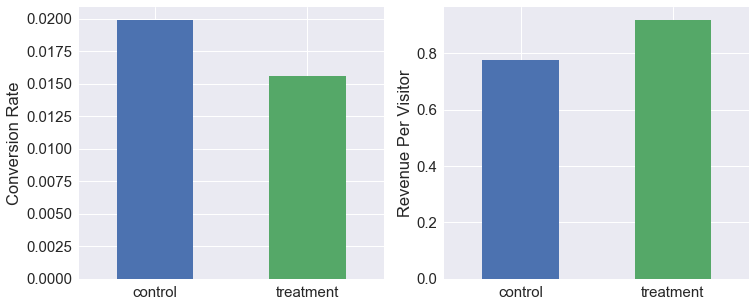

In [9]:
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
conversion.plot(kind='bar', x='test', y='converted', ax=ax1, legend=None)
plt.xlabel('')
plt.xticks(rotation=0, fontsize=15, ha='center')
plt.ylabel('Conversion Rate')


ax2 = fig.add_subplot(1,2,2)
conversion.plot(kind='bar', x='test', y='revenue', ax=ax2, legend=None)
plt.xlabel('')
plt.xticks(rotation=0, fontsize=15, ha='center')
plt.ylabel('Revenue Per Visitor')

plt.show()

Conversion rate is higher in control group, but average revenue is higher in treatment group.

In [10]:
table['test'] = table['test'].map({0:'control', 1:'treatment'})

In [11]:
# Bar plot for discrete variable

def barplot(df, var_col, tar_col, yscale='linear'):
    sns.countplot(x=var_col, hue=tar_col, data=df, order=df[var_col].value_counts().sort_index().index)
    plt.yscale(yscale)
    #plt.ylabel('count',  fontsize=15)
    #plt.xlabel(var_col, fontsize=15)
    #plt.legend(fontsize=15)
    return 

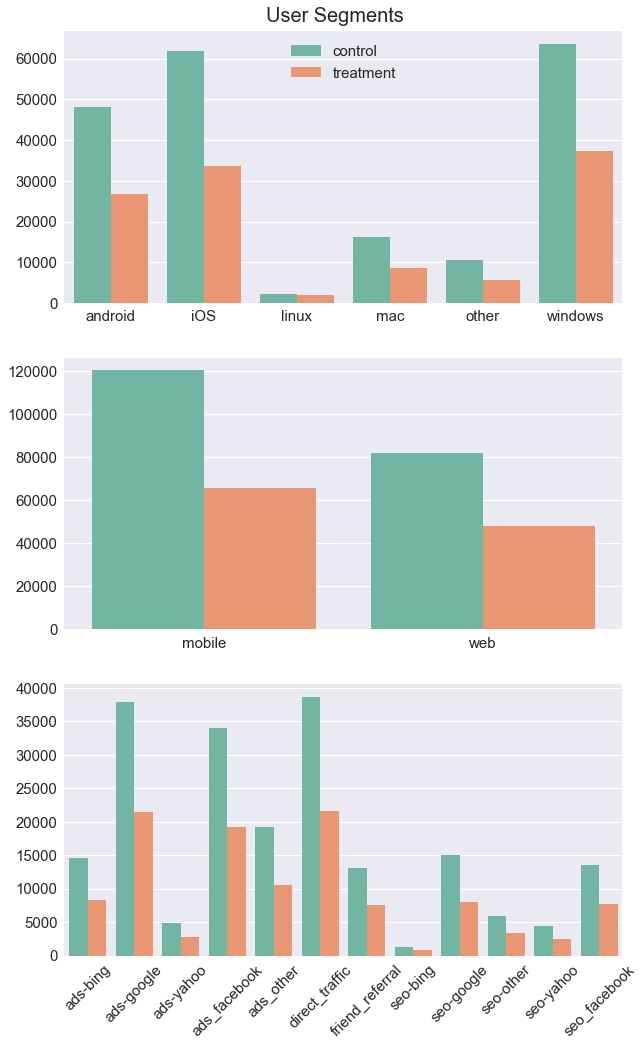

In [12]:
sns.set(font_scale=1.5, palette='Set2')
fig = plt.figure(figsize=(10,17))
ax1 = fig.add_subplot(3,1,3)
barplot(table, 'source', 'test')
plt.xticks(rotation=45, fontsize=15, ha='center')
plt.xlabel('')
plt.ylabel('')
plt.legend('')
#plt.title('Source', fontsize=15)

ax2 = fig.add_subplot(3,1,2)
barplot(table, 'device', 'test')
plt.xticks(rotation=0, fontsize=15, ha='center')
#plt.title('Device', fontsize=15)
plt.xlabel('')
plt.ylabel('')
plt.legend('')

ax3 = fig.add_subplot(3,1,1)
barplot(table, 'operative_system', 'test')
plt.xticks(rotation=0, fontsize=15, ha='center')
#plt.title('Operative system', fontsize=15)
plt.legend(fontsize=15)
plt.xlabel('')
plt.ylabel('')

fig.suptitle('User Segments', y=0.9, fontsize=20)


plt.show()

### Calculate conversion for each group

In [13]:
def conversion_segments(df, seg_col, test_col, conv_col):
    table = pd.pivot_table(df, values=conv_col, index=seg_col, columns=test_col, 
                           aggfunc=np.mean).rename_axis(None, axis=1).rename_axis(None, axis=0)
    return table

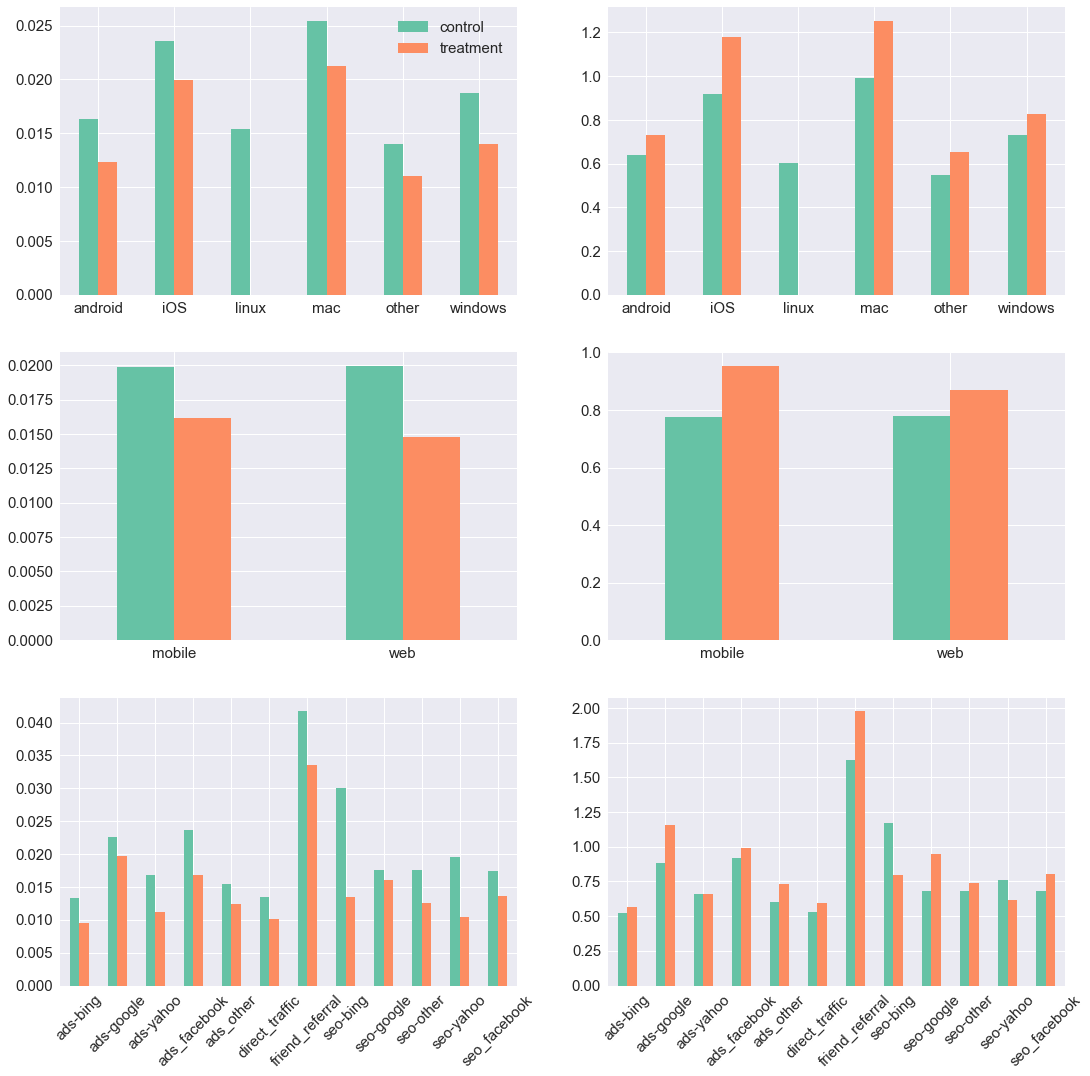

In [14]:
fig = plt.figure(figsize=(18,18))

for i, segment in enumerate(['operative_system', 'device', 'source']):
    for j, conv in enumerate(['converted', 'revenue']):
        ax = fig.add_subplot(3,2,i*2+j+1)
        #print(conversion_segments(table, segment, 'test', conversion))
        conversion_segments(table, segment, 'test', conv).plot(kind='bar', ax=ax)
        plt.xlabel('')
        plt.ylabel('')
        plt.legend('')
        plt.xticks(rotation=0, fontsize=15, ha='center')
        if i == 0 and j == 0:
            plt.legend()
        if i ==2:
            plt.xticks(rotation=45, fontsize=15, ha='center')
    


### If we look at RPV (revenue per visitor), treatment group is always winning for almost all segments, except for linux operative system. Possibly because linux system is mostly for users who are engineers doing work-related stuff and they are not supposed to shop while at work. 

### Also friend referal is not winning in treatment group. 

### Segments with high conversion rate and RPV are direct traffic, iOS and Mac users.

### Next, test if the difference is significant using Mann-Whitney U test (Wilcoxon rank sum test). Since RPV doesn't not meet assumption of normality, we cannot use t-test. 

In [15]:
from scipy import stats
X1 = table.loc[table['test']=='control', 'revenue']
X2 = table.loc[table['test']=='treatment', 'revenue']
stat, pval = stats.mannwhitneyu(X1, X2, alternative='greater')
print('H0: Treatment group has equal or lower RPV than control group')
print('H1: Treatment group has higher RPV than control group')
print('One-tailed p-value from Mann-Whitney U test is {0:.4f}'.format(pval))

H0: Treatment group has equal or lower RPV than control group
H1: Treatment group has higher RPV than control group
One-tailed p-value from Mann-Whitney U test is 0.0000


### Overall treatment group is winning. 

In [16]:
segments = ['operative_system', 'device', 'source']

print('Analyze AB testing results in user segments')
print('H0: Treatment group has equal or lower RPV than control group in the segment')
print('H1: Treatment group has higher RPV than control group in the segment')

for segment in segments:
    segvals = table[segment].value_counts().index.tolist()
    for segval in segvals:
        table_temp = table[table[segment]==segval]
        X1 = table_temp.loc[table['test']=='control', 'revenue']
        X2 = table_temp.loc[table['test']=='treatment', 'revenue']
        stat, pval = stats.mannwhitneyu(X1, X2, alternative='greater')
        print('For {0}, One-tailed p-value from Mann-Whitney U test is {1:.4f}'.format(segval,pval))

Analyze AB testing results in user segments
H0: Treatment group has equal or lower RPV than control group in the segment
H1: Treatment group has higher RPV than control group in the segment
For windows, One-tailed p-value from Mann-Whitney U test is 0.0000
For iOS, One-tailed p-value from Mann-Whitney U test is 0.0009
For android, One-tailed p-value from Mann-Whitney U test is 0.0000
For mac, One-tailed p-value from Mann-Whitney U test is 0.0353
For other, One-tailed p-value from Mann-Whitney U test is 0.0658
For linux, One-tailed p-value from Mann-Whitney U test is 0.0000
For mobile, One-tailed p-value from Mann-Whitney U test is 0.0000
For web, One-tailed p-value from Mann-Whitney U test is 0.0000
For direct_traffic, One-tailed p-value from Mann-Whitney U test is 0.0002
For ads-google, One-tailed p-value from Mann-Whitney U test is 0.0221
For ads_facebook, One-tailed p-value from Mann-Whitney U test is 0.0000
For ads_other, One-tailed p-value from Mann-Whitney U test is 0.0243
For se

### For each user segment, treatment group is also winning. 

In [17]:
X1 = table.loc[table['test']=='control', 'revenue']
X2 = table.loc[table['test']=='treatment', 'revenue']
var_pool = ((len(X1)-1)*np.var(X1.values) + (len(X2)-1)*np.var(X2.values))/(len(X1)+len(X2)-2)
sample_size = 2*var_pool/(conversion['revenue'][0]-conversion['revenue'][1])**2
sample_size

3804.426709330153

### A sample size of 3804 would be needed for each group when running AB testing. 

In [18]:
table['date'] = pd.to_datetime(table['timestamp'].str.split(expand=True).iloc[:,0])

In [19]:
kws={'histtype': 'bar', 'alpha': 0.5}
def histplot(df, var_col, tar_col, binsize=20, yscale='linear'):
    fig = plt.figure(figsize=(16,8))
    tar_vals = df[tar_col].value_counts().index
    for tar_val in tar_vals:
        sns.distplot(df.loc[df[tar_col]==tar_val, var_col], bins=binsize, hist=True, hist_kws=kws, kde=True, norm_hist=True, label=str(tar_val))
    plt.yscale(yscale)
    plt.ylabel('frequency',  fontsize=15)
    plt.xlabel(var_col, fontsize=15)
    plt.legend(fontsize=15)
    return 

<Figure size 1152x288 with 0 Axes>

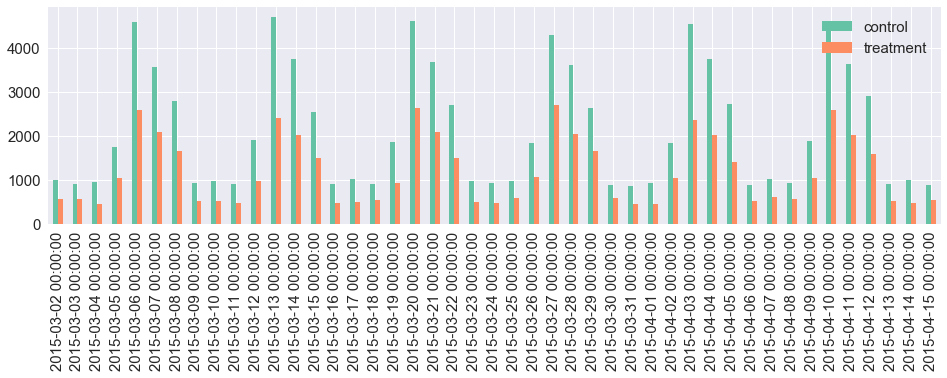

In [20]:

by_date = pd.DataFrame(table[table['test']=='control']['date'].value_counts())
by_date.columns=['control']

by_date2 = pd.DataFrame(table[table['test']=='treatment']['date'].value_counts())
by_date2.columns=['treatment']
by_date = pd.merge(by_date, by_date2,left_index=True, right_index=True)

by_date.sort_index(inplace=True)

fig = plt.figure(figsize=(16,4))
by_date.iloc[:int(by_date.shape[0]/2)].plot(kind='bar', figsize=(16,4))

18.7 62.18 -158.8 31.31


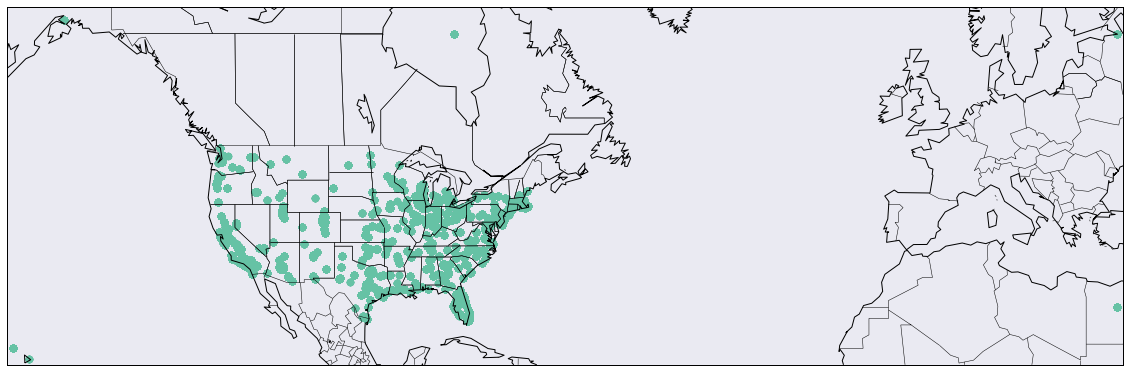

In [21]:
import warnings
warnings.filterwarnings('ignore')

lat_min = table.describe().loc['min','lat']-1
lat_max = table.describe().loc['max','lat']+1
lon_min = table.describe().loc['min','long']-1
lon_max = table.describe().loc['max','long']+1
print(lat_min, lat_max, lon_min, lon_max)

from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(20,10))
m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max)
m.drawcoastlines()
m.drawmapboundary()
#m.drawrivers()
m.drawcountries()
m.drawstates()

m.scatter(table['long'].tolist(), table['lat'].tolist(), latlon=True)
plt.show()

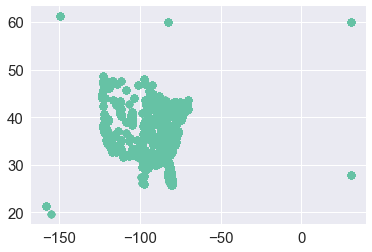

In [22]:
plt.scatter(table['long'].tolist(), table['lat'])

### Let's remove datapoints outside of US

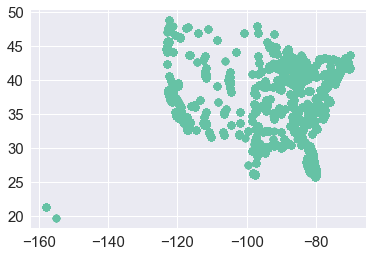

In [23]:
table = table[(table['lat']<50) & (table['long']<-50)]
table['test'] = table['test'].map({'control':0, 'treatment':1})
plt.scatter(table['long'].tolist(), table['lat'])

18.7 49.74 -158.8 -69.08


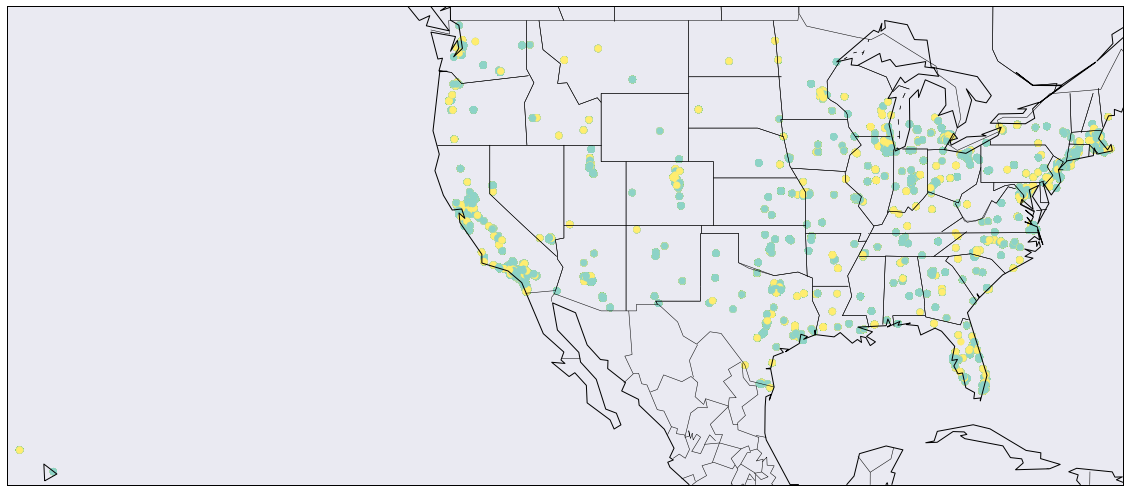

In [27]:
lat_min = table.describe().loc['min','lat']-1
lat_max = table.describe().loc['max','lat']+1
lon_min = table.describe().loc['min','long']-1
lon_max = table.describe().loc['max','long']+1
print(lat_min, lat_max, lon_min, lon_max)

from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(20,10))
m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max)
m.drawcoastlines()
m.drawmapboundary()
#m.drawrivers()
m.drawcountries()
m.drawstates()

m.scatter(table['long'].tolist(), table['lat'].tolist(), c=table['test'], cmap='Set3', latlon=True)
plt.show()

### Control and treatment groups are randomly splitted across US. 

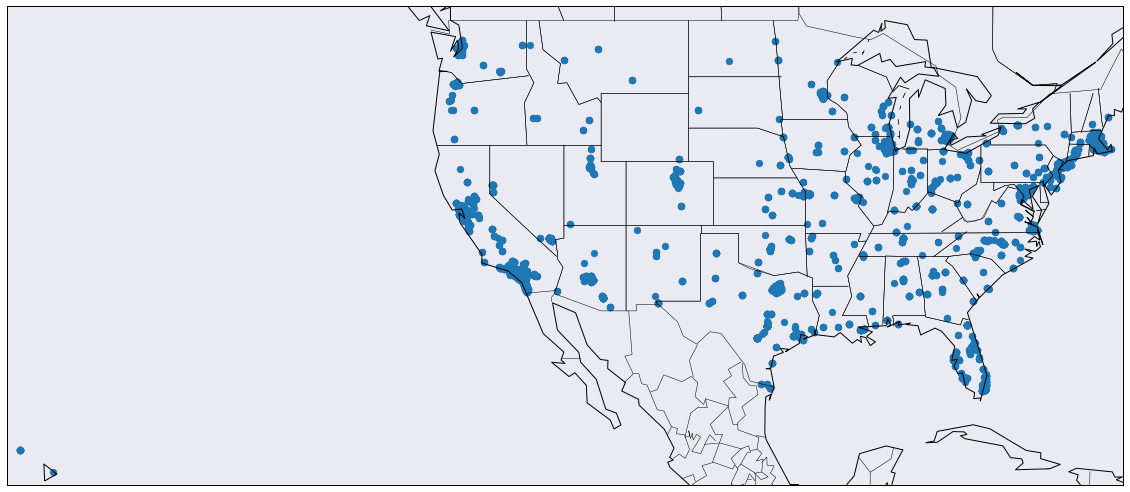

In [29]:
fig = plt.figure(figsize=(20,10))
m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max)
m.drawcoastlines()
m.drawmapboundary()
#m.drawrivers()
m.drawcountries()
m.drawstates()

table_temp = table[table['converted']==1]
m.scatter(table_temp['long'].tolist(), table_temp['lat'].tolist(), cmap='Pastel1', latlon=True)
plt.show()

### Converted users are also distributed randomly. 